In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from datetime import datetime
from tensorflow import keras
from tensorflow.keras.callbacks import Callback

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Load the data
df = pd.read_csv('/content/drive/MyDrive/Task2/Steel_industry_data.csv')

In [4]:
df.head(2)

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load


In [5]:
#Info for Dtypes and non-null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  35040 non-null  object 
 1   Usage_kWh                             35040 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 4   CO2(tCO2)                             35040 non-null  float64
 5   Lagging_Current_Power_Factor          35040 non-null  float64
 6   Leading_Current_Power_Factor          35040 non-null  float64
 7   NSM                                   35040 non-null  int64  
 8   WeekStatus                            35040 non-null  object 
 9   Day_of_week                           35040 non-null  object 
 10  Load_Type                             35040 non-null  object 
dtypes: float64(6), 

In [6]:
#Rename the columns for simplicity
df = df.rename(columns={'CO2(tCO2)': 'tco2',
                        'Lagging_Current_Reactive.Power_kVarh': 'lagging_kvarh',
                        'Leading_Current_Reactive_Power_kVarh': 'leading_kvarh',
                       'Lagging_Current_Power_Factor': 'lagging_pf',
                       'Leading_Current_Power_Factor': 'leading_pf'})

In [7]:
#Change all column names into lowercase
df.columns = df.columns.str.lower()

In [8]:
#Check for null values
print("NA values: " , df.isna().sum().sum())
print("Null values: ", df.isnull().sum().sum())

NA values:  0
Null values:  0


In [9]:
#Create new column and drop the old one
df["kgco2"] = df.tco2 * 1000
df.drop('tco2', inplace=True, axis=1)

In [10]:
df.head(2)

,date,usage_kwh,lagging_kvarh,leading_kvarh,lagging_pf,leading_pf,nsm,weekstatus,day_of_week,load_type,kgco2
0,01/01/2018 00:15,3.17,2.95,0.0,73.21,100.0,900,Weekday,Monday,Light_Load,0.0
1,01/01/2018 00:30,4.00,4.46,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load,0.0


In [11]:
unique_values = df['weekstatus'].unique()
unique_values

array(['Weekday', 'Weekend'], dtype=object)

In [12]:
def preprocessing_column(dataframe, old_name, new_name, function):
    dataframe[new_name] = df[old_name].apply(function)
    dataframe.drop(old_name, axis = 1, inplace=True)

def encoding_day_of_week(value):
    mapping = {
          'Monday': 2,
          'Tuesday': 3,
          'Wednesday': 4,
          'Thursday': 5,
          'Friday': 6,
          'Saturday': 7,
          'Sunday': 1
      }
    return mapping.get(value)
def encoding_load_type(value):
    mapping = {
          'Light_Load': 0,
          'Medium_Load': 1,
          'Maximum_Load': 2,
      }
    return mapping.get(value)
def encoding_weekstatus(value):
    mapping = {
          'Weekday': 0,
          'Weekend': 1,
      }
    return mapping.get(value)
def encoding_date(value):
    date_obj = datetime.strptime(value, '%d/%m/%Y %H:%M')
    hour = date_obj.hour
    minute = date_obj.minute

    encoded_value = (hour * 60 + minute) // 15
    return encoded_value

In [13]:
preprocessing_column(df,'day_of_week', 'new_day_of_week', encoding_day_of_week)
preprocessing_column(df,'load_type', 'new_load_type', encoding_load_type)
preprocessing_column(df,'date', 'new_date', encoding_date)
preprocessing_column(df,'weekstatus', 'new_weekstatus', encoding_weekstatus)

In [14]:
df.head(2)

,usage_kwh,lagging_kvarh,leading_kvarh,lagging_pf,leading_pf,nsm,kgco2,new_day_of_week,new_load_type,new_date,new_weekstatus
0,3.17,2.95,0.0,73.21,100.0,900,0.0,2,0,1,0
1,4.00,4.46,0.0,66.77,100.0,1800,0.0,2,0,2,0


In [15]:
Y = df['usage_kwh'].to_numpy()
X = df.drop('usage_kwh', axis =1). to_numpy()

In [16]:
X_3D = X.reshape((X.shape[0], X.shape[1], 1))
Y_3D = Y.reshape((Y.shape[0], 1))

In [17]:
X_3D.shape, Y_3D.shape

((35040, 10, 1), (35040, 1))

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X_3D, Y_3D, test_size=0.2, random_state= 128)

In [19]:
class MetricsHistory(Callback):
    def __init__(self, x_train, y_train, tittle_graph, path_tosaveImg):
        super(MetricsHistory, self).__init__()
        self.metrics_values = {
            'mse': [],
            'rmse': [],
            'r_squared': [],
            'loss': []
        }
        self.epoch_values = []
        self.x_train = x_train
        self.y_train = y_train
        self.tittle_graph = tittle_graph
        self.path_tosaveImg = path_tosaveImg

    def on_epoch_end(self, epoch, logs=None):
        y_true = self.y_train
        y_pred = self.model.predict(self.x_train)

        mse, rmse, r_squared = calculate_metrics(y_true, y_pred)
        loss = logs['loss']

        self.metrics_values['mse'].append(mse)
        self.metrics_values['rmse'].append(rmse)
        self.metrics_values['r_squared'].append(r_squared)
        self.metrics_values['loss'].append(loss)
        self.epoch_values.append(epoch + 1)

    def on_train_end(self, logs=None):
        plt.figure(1)
        plt.plot(self.epoch_values, self.metrics_values['mse'], 'b-', label='MSE')
        plt.plot(self.epoch_values, self.metrics_values['rmse'], 'r-', label='RMSE')
        plt.plot(self.epoch_values, self.metrics_values['r_squared'], 'g-', label='R^2')
        plt.xlabel('Epochs')
        plt.ylabel('Metrics')
        plt.title(self.tittle_graph[0])
        plt.legend()
        plt.savefig( self.path_tosaveImg[0] )

        plt.figure(2)
        plt.plot(self.epoch_values, self.metrics_values['loss'], 'y-', label='Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(self.tittle_graph[1])
        plt.legend()
        plt.savefig( self.path_tosaveImg[1])

        plt.show()

def calculate_metrics(y_true, y_pred):
    n = len(y_true)
    mse = np.mean((y_true - y_pred)**2)
    rmse = np.sqrt(mse)
    ss_total = np.sum((y_true - np.mean(y_true))**2)
    ss_residual = np.sum((y_true - y_pred)**2)
    r_squared = 1 - (ss_residual / ss_total)
    return mse, rmse, r_squared

Epoch 1/1200
110/110 [==============================] - 7s 58ms/step - loss: 1365.3337 - val_loss: 1167.6522
Epoch 2/1200
110/110 [==============================] - 3s 27ms/step - loss: 1013.4993 - val_loss: 891.5206
Epoch 3/1200
110/110 [==============================] - 3s 29ms/step - loss: 789.8973 - val_loss: 705.6199
Epoch 4/1200
110/110 [==============================] - 3s 24ms/step - loss: 629.0119 - val_loss: 566.0012
Epoch 5/1200
110/110 [==============================] - 4s 34ms/step - loss: 508.1308 - val_loss: 461.5269
Epoch 6/1200
110/110 [==============================] - 3s 27ms/step - loss: 418.6964 - val_loss: 384.5690
Epoch 7/1200
110/110 [==============================] - 3s 29ms/step - loss: 352.8290 - val_loss: 324.6999
Epoch 8/1200
110/110 [==============================] - 2s 23ms/step - loss: 296.5005 - val_loss: 273.4092
Epoch 9/1200
110/110 [==============================] - 3s 24ms/step - loss: 250.8156 - val_loss: 233.0899
Epoch 10/1200
110/110 [===========

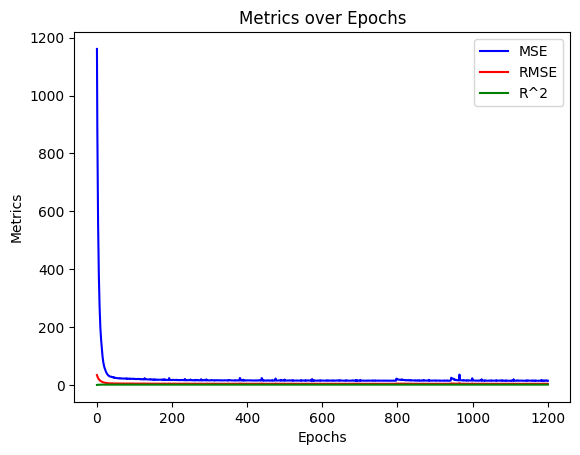

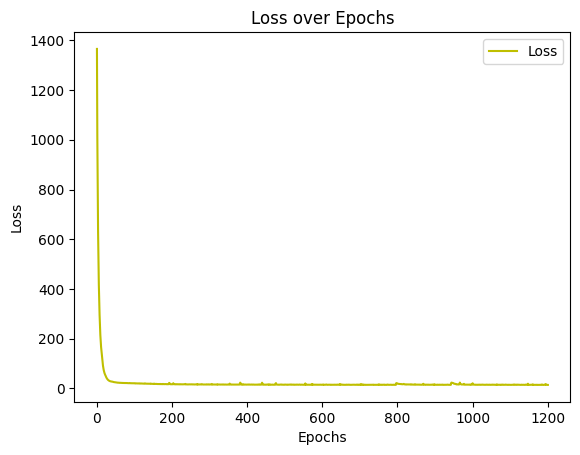

In [20]:
model_RNN = keras.Sequential()
model_RNN.add(keras.layers.SimpleRNN(units = 64, input_shape=(X_train.shape[1], X_train.shape[2])))
model_RNN.add(keras.layers.Dense(units=1))
model_RNN.compile(optimizer='adam', loss='mse')
metrics_history_callback = MetricsHistory(X_train, Y_train,['Metrics over Epochs on RNN','Loss over Epochs on RNN'],['/content/drive/MyDrive/Task2/metricsRNN.png', '/content/drive/MyDrive/Task2/lossRNN.png'] )
model_RNN.fit(X_train, Y_train,validation_data =(X_test, Y_test), epochs= 1200, batch_size= 256, callbacks=[metrics_history_callback])


In [21]:
model_RNN.save('/content/drive/MyDrive/Task2/model/RNN_model.keras')

In [22]:
Y_pred = model_RNN.predict(X_test)
mse, rmse, r_squared = calculate_metrics(Y_test, Y_pred)
print("Metric for RNN")
print("MSE = "+str(mse))
print("RMSE = "+str(rmse))
print("R^2 = "+str(r_squared))

219/219 [==============================] - 0s 2ms/step
Metric for RNN
MSE = 19.31426599458422
RMSE = 4.3947998810621876
R^2 = 0.9828158195374795


Epoch 1/1500
110/110 [==============================] - 12s 90ms/step - loss: 1509.0731 - val_loss: 1249.4718
Epoch 2/1500
110/110 [==============================] - 5s 46ms/step - loss: 1074.2380 - val_loss: 928.9753
Epoch 3/1500
110/110 [==============================] - 7s 63ms/step - loss: 818.3519 - val_loss: 725.4814
Epoch 4/1500
110/110 [==============================] - 5s 46ms/step - loss: 642.9771 - val_loss: 576.1326
Epoch 5/1500
110/110 [==============================] - 7s 69ms/step - loss: 514.9670 - val_loss: 465.3762
Epoch 6/1500
110/110 [==============================] - 5s 46ms/step - loss: 420.1598 - val_loss: 385.1001
Epoch 7/1500
110/110 [==============================] - 5s 48ms/step - loss: 347.9165 - val_loss: 319.5042
Epoch 8/1500
110/110 [==============================] - 7s 64ms/step - loss: 292.7372 - val_loss: 270.8737
Epoch 9/1500
110/110 [==============================] - 8s 70ms/step - loss: 245.5832 - val_loss: 227.4552
Epoch 10/1500
110/110 [==========

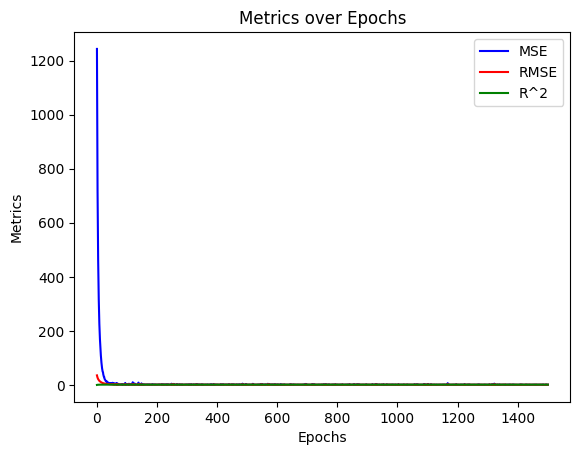

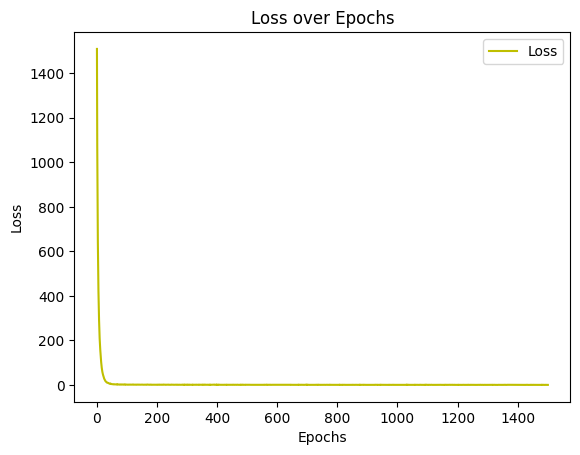

In [23]:
model_LSTM = keras.Sequential()
model_LSTM.add(keras.layers.LSTM(units = 64, input_shape=(X_train.shape[1], X_train.shape[2])))
model_LSTM.add(keras.layers.Dense(units=1))
model_LSTM.compile(optimizer='adam', loss='mse')
metrics_history_callback = MetricsHistory(X_train, Y_train,['Metrics over Epochs on LSTM','Loss over Epochs on LSTM'],['/content/drive/MyDrive/Task2/metricsLSTM.png', '/content/drive/MyDrive/Task2/lossLSTM.png'] )
model_LSTM.fit(X_train, Y_train,validation_data =(X_test, Y_test), epochs= 1500, batch_size= 256, callbacks=[metrics_history_callback])

In [24]:
model_LSTM.save('/content/drive/MyDrive/Task2/model/LSTM_model.keras')

In [25]:
Y_pred = model_LSTM.predict(X_test)
mse, rmse, r_squared = calculate_metrics(Y_test, Y_pred)
print("Metric for LSTM")
print("MSE = "+str(mse))
print("RMSE = "+str(rmse))
print("R^2 = "+str(r_squared))

219/219 [==============================] - 1s 3ms/step
Metric for LSTM
MSE = 1.0058167773033988
RMSE = 1.0029041715455165
R^2 = 0.9991051103356318


Epoch 1/1500
110/110 [==============================] - 9s 65ms/step - loss: 1460.4922 - val_loss: 1254.8798
Epoch 2/1500
110/110 [==============================] - 4s 41ms/step - loss: 1083.6011 - val_loss: 927.3832
Epoch 3/1500
110/110 [==============================] - 4s 38ms/step - loss: 811.6473 - val_loss: 718.2593
Epoch 4/1500
110/110 [==============================] - 6s 56ms/step - loss: 639.8430 - val_loss: 575.4385
Epoch 5/1500
110/110 [==============================] - 4s 36ms/step - loss: 520.0354 - val_loss: 476.5615
Epoch 6/1500
110/110 [==============================] - 4s 40ms/step - loss: 437.3253 - val_loss: 407.3375
Epoch 7/1500
110/110 [==============================] - 8s 70ms/step - loss: 381.1639 - val_loss: 361.1662
Epoch 8/1500
110/110 [==============================] - 4s 40ms/step - loss: 344.4539 - val_loss: 331.4517
Epoch 9/1500
110/110 [==============================] - 4s 40ms/step - loss: 320.1382 - val_loss: 306.0440
Epoch 10/1500
110/110 [===========

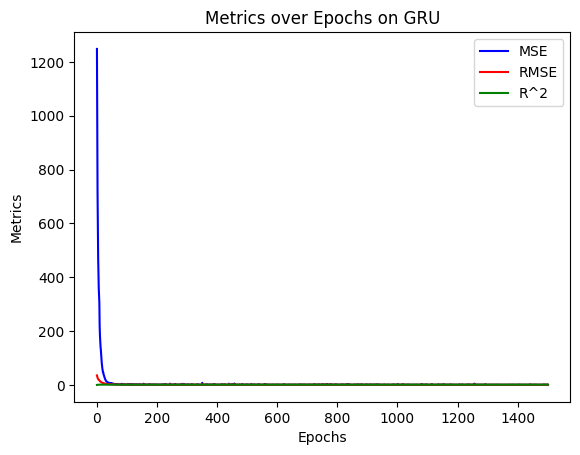

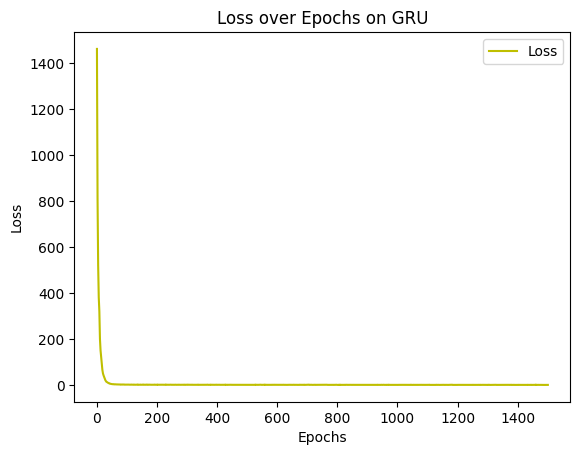

In [20]:
model_GRU = keras.Sequential()
model_GRU.add(keras.layers.GRU(units = 64, input_shape=(X_train.shape[1], X_train.shape[2])))
model_GRU.add(keras.layers.Dense(units=1))
model_GRU.compile(optimizer='adam', loss='mse')
metrics_history_callback = MetricsHistory(X_train, Y_train,['Metrics over Epochs on GRU','Loss over Epochs on GRU'],['/content/drive/MyDrive/Task2/metricsGRU.png', '/content/drive/MyDrive/Task2/lossGRU.png'] )
model_GRU.fit(X_train, Y_train,validation_data =(X_test, Y_test), epochs= 1500, batch_size= 256, callbacks=[metrics_history_callback])

In [21]:
model_GRU.save('/content/drive/MyDrive/Task2/model/GRU_model.keras')

In [22]:
Y_pred = model_GRU.predict(X_test)
mse, rmse, r_squared = calculate_metrics(Y_test, Y_pred)
print("Metric for LSTM")
print("MSE = "+str(mse))
print("RMSE = "+str(rmse))
print("R^2 = "+str(r_squared))

219/219 [==============================] - 1s 2ms/step
Metric for LSTM
MSE = 0.9293396631862973
RMSE = 0.9640226466148486
R^2 = 0.9991731531248638


In [23]:
model_GRU_multilayers = keras.Sequential()
model_GRU_multilayers.add(keras.layers.GRU(units = 64,return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_GRU_multilayers.add( keras.layers.Dropout(0.2))
model_GRU_multilayers.add(keras.layers.GRU(units = 64,return_sequences=True))
model_GRU_multilayers.add( keras.layers.Dropout(0.2))
model_GRU_multilayers.add(keras.layers.GRU(units = 64,return_sequences=True))
model_GRU_multilayers.add( keras.layers.Dropout(0.2))
model_GRU_multilayers.add(keras.layers.GRU(units = 64))
model_GRU_multilayers.add( keras.layers.Dropout(0.2))
model_GRU_multilayers.add(keras.layers.Dense(units=1))
model_GRU_multilayers.compile(optimizer='adam', loss='mse')
metrics_history_callback = MetricsHistory(X_train, Y_train,['Metrics over Epochs on GRU multilayers','Loss over Epochs on GRU multilayers'],['/content/drive/MyDrive/Task2/metricsGRU_multilayer.png', '/content/drive/MyDrive/Task2/lossGRU_multilayer.png'] )
model_GRU_multilayers.fit(X_train, Y_train,validation_data =(X_test, Y_test), epochs= 1500, batch_size= 256, callbacks=[metrics_history_callback])

Epoch 1/1500
110/110 [==============================] - 32s 224ms/step - loss: 1376.2560 - val_loss: 1245.5465
Epoch 2/1500
110/110 [==============================] - 17s 154ms/step - loss: 1191.4701 - val_loss: 1159.9174
Epoch 3/1500
110/110 [==============================] - 22s 204ms/step - loss: 1139.8580 - val_loss: 1132.3595
Epoch 4/1500
110/110 [==============================] - 21s 192ms/step - loss: 1114.2310 - val_loss: 1045.2646
Epoch 5/1500
110/110 [==============================] - 17s 153ms/step - loss: 756.1772 - val_loss: 622.3644
Epoch 6/1500
110/110 [==============================] - 17s 153ms/step - loss: 513.1135 - val_loss: 435.3492
Epoch 7/1500
110/110 [==============================] - 17s 157ms/step - loss: 388.6322 - val_loss: 341.2043
Epoch 8/1500
110/110 [==============================] - 18s 162ms/step - loss: 311.3534 - val_loss: 272.9077
Epoch 9/1500
110/110 [==============================] - 20s 186ms/step - loss: 251.3139 - val_loss: 221.1032
Epoch 10/15

KeyboardInterrupt: 